In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from segment_anything import SamPredictor, sam_model_registry
from PIL import Image, ImageEnhance
import json
from utils import *
import math
import numpy as np
import matplotlib.colors as mcolors
from scipy.spatial import KDTree
from helper_code.graph_reconstruction import *
from helper_code.mask_detection import *
from helper_code.metadata_extraction import *
from helper_code.color_detection import *
from webcolors import (
    CSS3_HEX_TO_NAMES,
    hex_to_rgb,
)

In [2]:
def get_all_color_names():
    css3_db = CSS3_HEX_TO_NAMES
    color_names = []
    color_rgb_values = []
    for color_hex, color_name in css3_db.items():
        color_names.append(color_name)
        color_rgb_values.append(hex_to_rgb(color_hex))
    return color_names, color_rgb_values

In [3]:
COLOR_NAMES, COLOR_RGB_VALUES = get_all_color_names()
KDT_DB = KDTree(COLOR_RGB_VALUES)

In [4]:
def convert_rgb_to_names(rgb_tuple, memo):
    distance, index = KDT_DB.query(rgb_tuple)

    # print(f'closest match: {COLOR_NAMES[index]}')

    simple_color = complex_to_simple_color[COLOR_NAMES[index]]
    memo[simple_color] = memo.get(simple_color, 0) + 1
    return simple_color

In [5]:
def get_color_masks(image_name, rgb_colors):
    image = Image.open(image_name)
    image = image.convert('RGB')
    filter = ImageEnhance.Contrast(image)
    image = filter.enhance(2)

    width, height = image.size
    masks = {}
    for c in rgb_colors:
        masks[c] = np.zeros((width, height))
    
    memo = {}
    for y in range(0, height):
        for x in range(0, width):

            r, g, b = image.getpixel((x, y))

            new_color = convert_rgb_to_names([r,g,b], memo)

            if new_color in rgb_colors:
                masks[new_color][x, y] = 1
                
    return masks, width, height, memo

In [6]:
## COLOR DETECTION

def get_points_new(color_masks, width, height, boundingBox, color, wBox, hBox, x_axis, y_axis):

    graph = []
    mask = color_masks[color]

    for x0 in range(boundingBox["topLeft"][0], boundingBox["bottomRight"][0], wBox):
        for y0 in range(boundingBox["topLeft"][1], boundingBox["bottomRight"][1], hBox):
            
            x, y = get_middle_coordinate(x0, y0, wBox, hBox)
            value = get_filtered_answer(mask, x0, y0, wBox, hBox, boundingBox["bottomRight"][0], boundingBox["bottomRight"][1])

            if value: 
                graph.append({
                "topLeft": (x0, y0), 
                "middle": convertPoint((x,y), boundingBox, width, height, x_axis, y_axis), 
                })
    
    return graph

In [7]:
## HELPER FUNCTION
def is_valid_color(color):
    try:
        mcolors.to_rgba(color)
        return True
    except ValueError:
        return False

In [8]:
def do_analysis(image_number, predictor):
    image_name = '../plot_images/'+str(image_number)+'.png'
    image = cv2.imread(image_name)

    height, width = image.shape[:2]
    input_point = np.array([[width // 2 - 50, height // 2 - 50], [width // 2 - 50, height // 2 + 50], [width // 2 + 50, height // 2 - 50], [width // 2 + 50, height // 2 + 50]])
    input_label = np.array([1, 1, 1, 1])

    predictor.set_image(image)

    masks, scores, logits = predictor.predict(
            point_coords=input_point,
            point_labels=input_label,
            multimask_output=True,
        )
    main_mask, main_mask_score = get_main_mask(masks, scores)

    n_image = image.copy()
    new_image, boundingBox = get_bounding_box(main_mask, n_image)

    points = np.array([
        boundingBox["topLeft"], 
        [boundingBox["topLeft"][0], boundingBox["bottomRight"][1]], 
        [boundingBox["bottomRight"][0], boundingBox["topLeft"][1]], 
        boundingBox["bottomRight"]
    ])
    
    return image_name, boundingBox

In [9]:
def do_complete_analysis(wBox, hBox, metadata, image_name, boundingBox, onlyColorsInImage = False, distance_type = "euclidean"):

    x_axis = metadata["x-axis"]["range"]
    y_axis = metadata["y-axis"]["range"]
    x_axis_title = metadata["x-axis"]["title"]
    y_axis_title = metadata["y-axis"]["title"]

    axis_labels = []
    rgb_colors = []
    coordinates = []
    for label, color in metadata["types"]:
        axis_labels.append(label)
        rgb_colors.append(color)
    
    color_masks, width, height, memo = get_color_masks(image_name, rgb_colors)

    print("This image has the following colors", memo)

    for color in rgb_colors:
        coordinates.append(get_points_new(color_masks, width, height, boundingBox, color, wBox, hBox, x_axis, y_axis))

    return coordinates, x_axis_title, y_axis_title, axis_labels, rgb_colors, x_axis, y_axis, memo

In [10]:
sam = sam_model_registry["default"](checkpoint="../../../Downloads/sam_vit_h_4b8939.pth")
predictor = SamPredictor(sam)

In [ ]:
import matplotlib.pyplot as plt

for image_num in range(1, 29):
    print("IMAGE NUMBER", image_num)
    prompt = {}
    with open('../plot_json/'+str(image_num)+'.json', 'r') as file:
        prompt = json.load(file)
    image_name, boundingBox = do_analysis(image_num, predictor)

    coordinates, x_axis_title, y_axis_title, axis_labels, rgb_colors, x_range, y_range, memo = do_complete_analysis(1, 1, prompt, image_name, boundingBox, False)

    plt.figure()
    for index, value in enumerate(coordinates):
        x = []
        y = []

        for i in range(len(value)):
            x.append(value[i]["middle"][0])
            y.append(value[i]["middle"][1])

        color_normalized = rgb_colors[index]

        if (is_valid_color(color_normalized)): plt.scatter(x, y, label=axis_labels[index], color=color_normalized)

    plt.xlim(x_range[0], x_range[1])
    plt.ylim(y_range[0], y_range[1])
    plt.xlabel(x_axis_title)
    plt.ylabel(y_axis_title)
    plt.legend()
    plt.show()

    

IMAGE NUMBER 1
This image has the following colors {'white': 134671, 'grey': 3534, 'black': 5093, 'blue': 2134, 'green': 43, 'pink': 1038, 'orange': 6, 'gray': 29, 'purple': 587, 'yellow': 1}


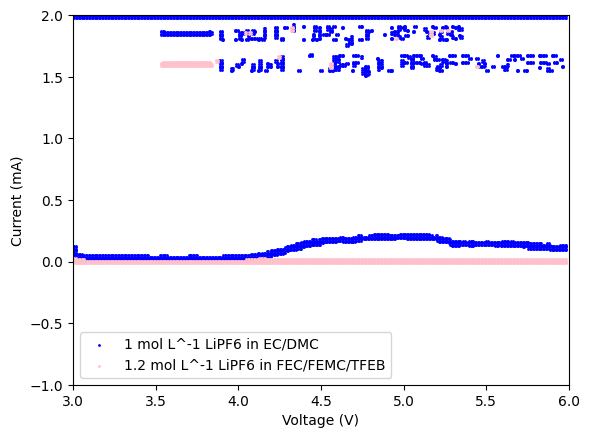

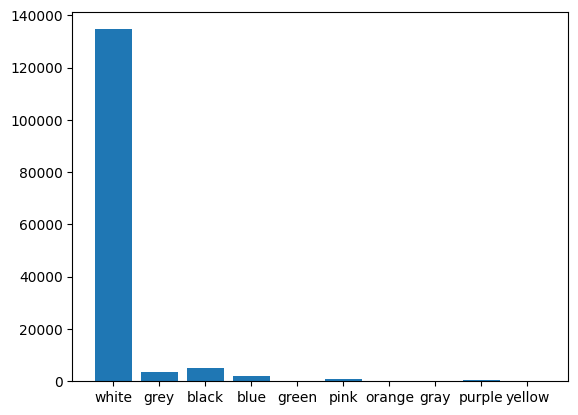

IMAGE NUMBER 2
This image has the following colors {'white': 125938, 'grey': 5289, 'black': 6668, 'blue': 1839, 'gray': 63, 'green': 206, 'pink': 1568, 'orange': 55, 'red': 106, 'purple': 1218, 'yellow': 2}


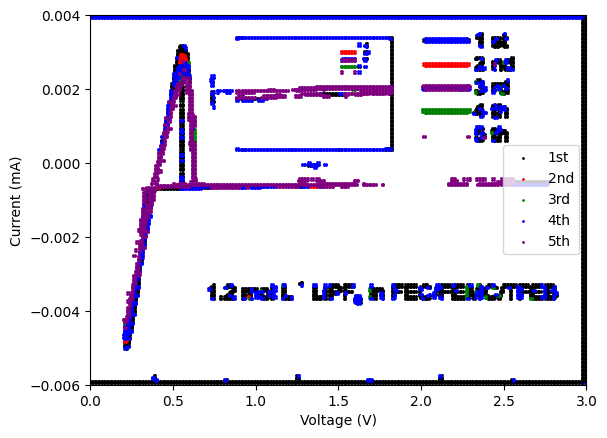

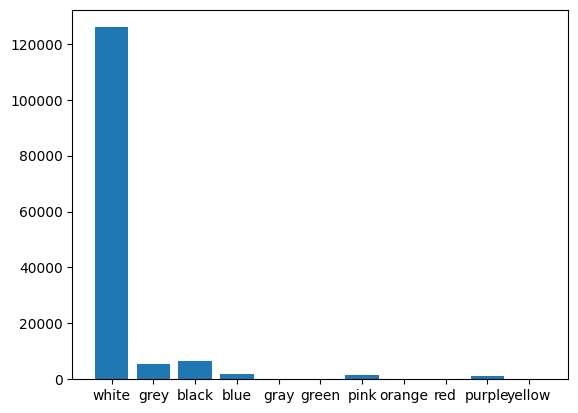

IMAGE NUMBER 3
This image has the following colors {'white': 125980, 'grey': 3973, 'black': 5532, 'blue': 1307, 'gray': 33, 'purple': 1668, 'green': 182, 'pink': 1993, 'red': 118, 'orange': 41, 'yellow': 5}


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


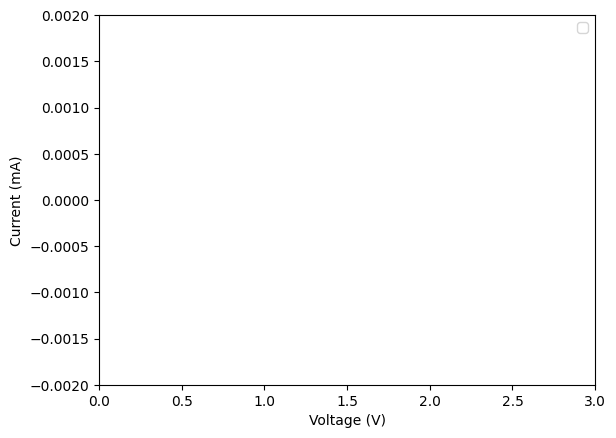

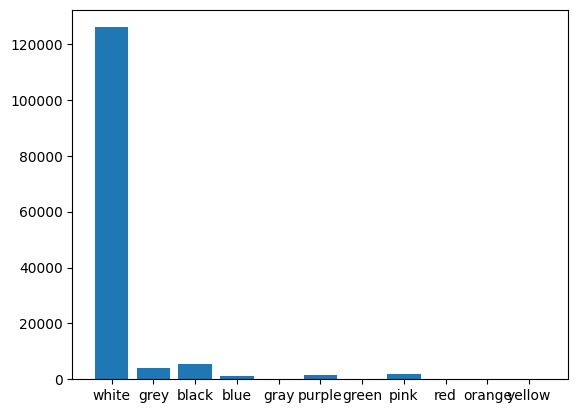

IMAGE NUMBER 4
This image has the following colors {'white': 114370, 'grey': 5345, 'black': 7880, 'pink': 1360, 'gray': 85, 'blue': 4370, 'green': 3027, 'red': 1211, 'orange': 462, 'purple': 1990, 'yellow': 80}


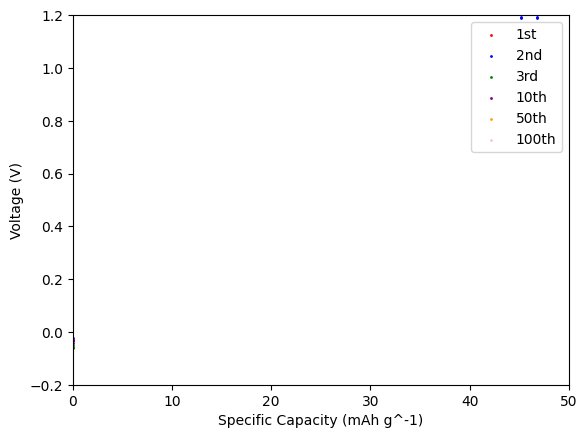

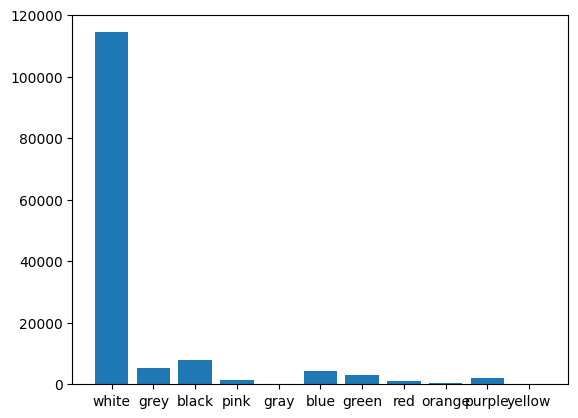

IMAGE NUMBER 5
This image has the following colors {'white': 118835, 'grey': 3962, 'blue': 4749, 'green': 111, 'black': 6051, 'yellow': 49, 'pink': 2783, 'purple': 385, 'orange': 128, 'gray': 78, 'red': 13}


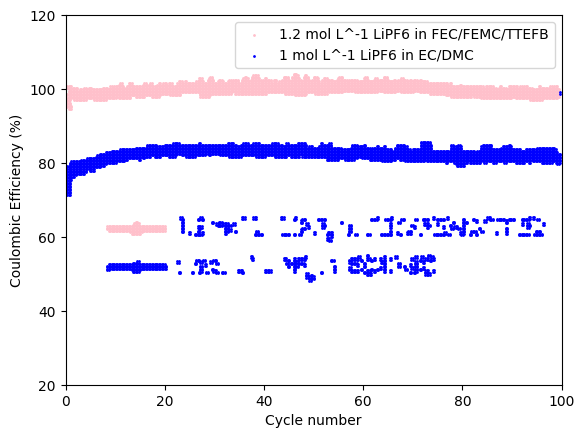

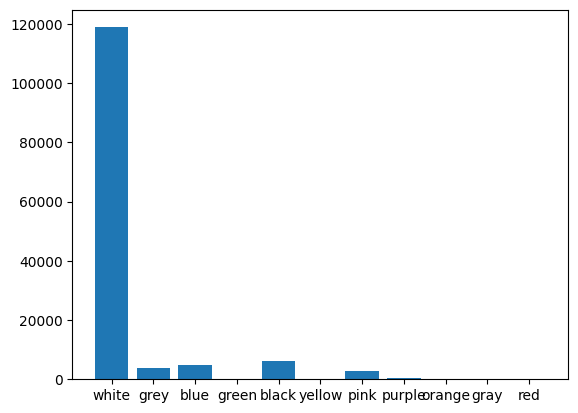

IMAGE NUMBER 6
This image has the following colors {'white': 108567, 'grey': 4640, 'blue': 3913, 'black': 7834, 'green': 3727, 'gray': 121, 'purple': 2230, 'orange': 375, 'red': 949, 'pink': 862, 'yellow': 134}


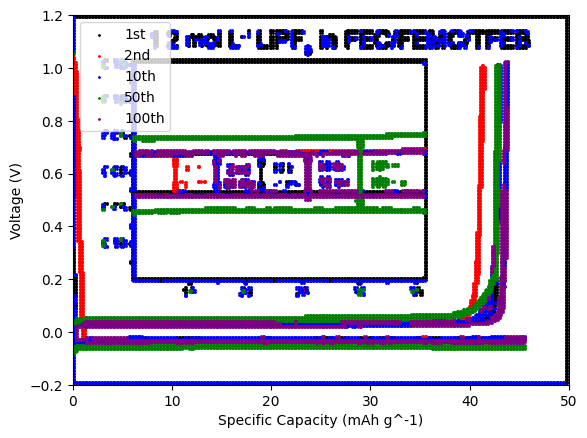

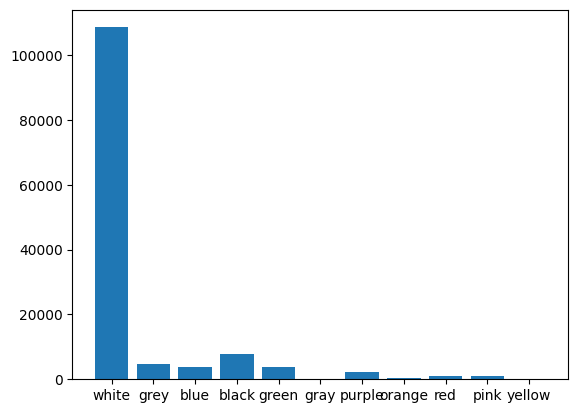

IMAGE NUMBER 7
This image has the following colors {'white': 277375, 'grey': 10967, 'blue': 12104, 'black': 9385, 'purple': 3168, 'gray': 56, 'green': 5657, 'yellow': 263, 'orange': 2055, 'red': 51, 'pink': 4483}


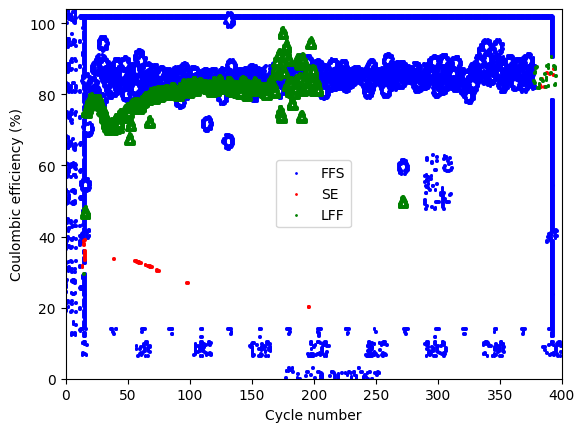

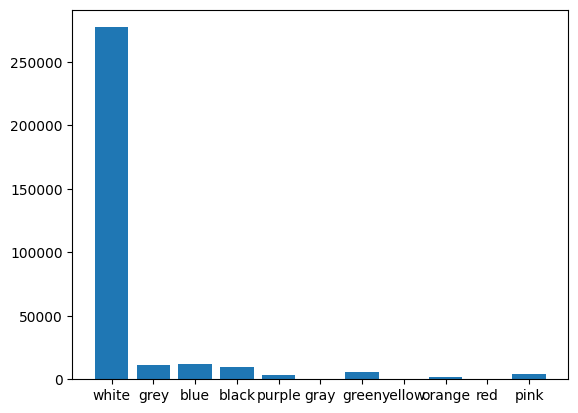

IMAGE NUMBER 8
This image has the following colors {'white': 149709, 'grey': 5670, 'black': 7039, 'blue': 4482, 'orange': 1088, 'yellow': 420, 'red': 63, 'pink': 19, 'green': 4311, 'purple': 197, 'gray': 2}


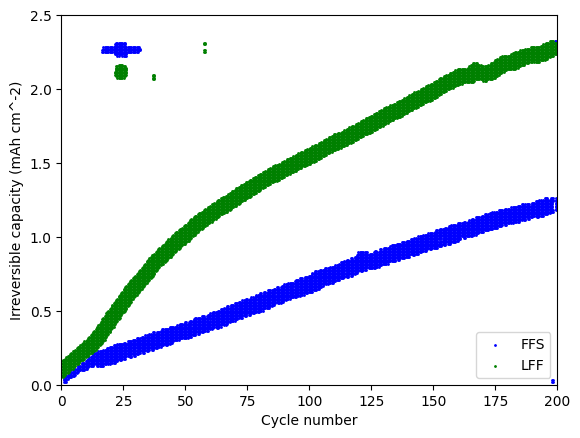

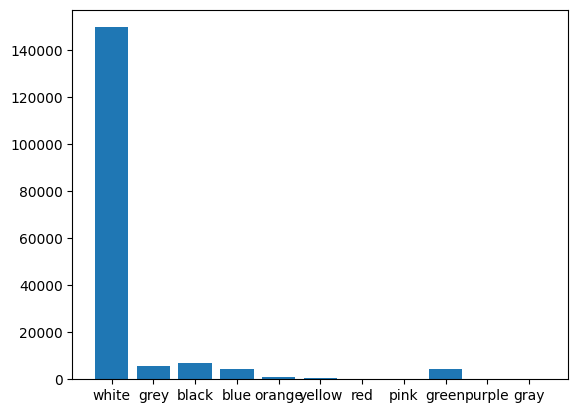

IMAGE NUMBER 9


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


This image has the following colors {'white': 124973, 'grey': 8863, 'blue': 2996, 'black': 10268, 'purple': 500, 'gray': 85, 'pink': 1999, 'green': 2554, 'orange': 4923, 'red': 925, 'yellow': 1938}


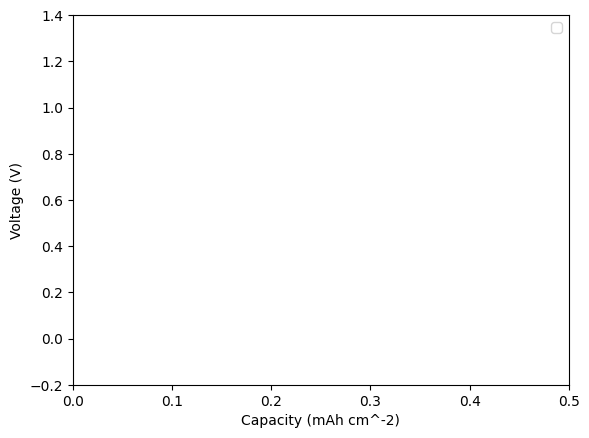

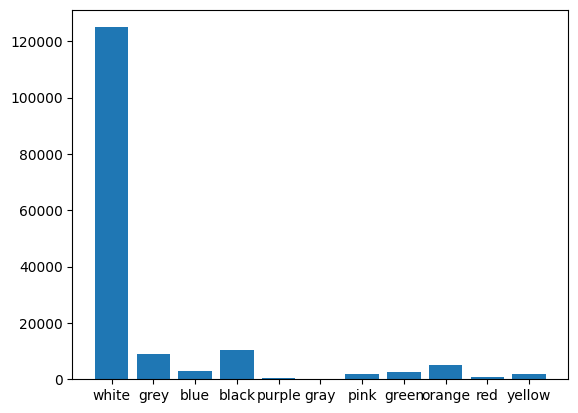

IMAGE NUMBER 10
This image has the following colors {'white': 133995, 'grey': 3787, 'blue': 12500, 'black': 4812, 'yellow': 968, 'orange': 2706, 'red': 26308, 'pink': 1995, 'green': 6, 'purple': 411}


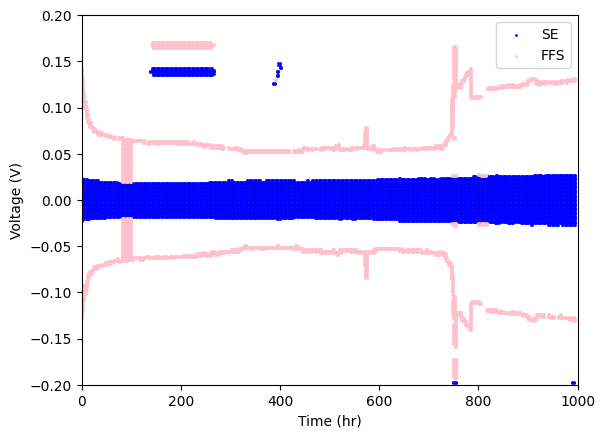

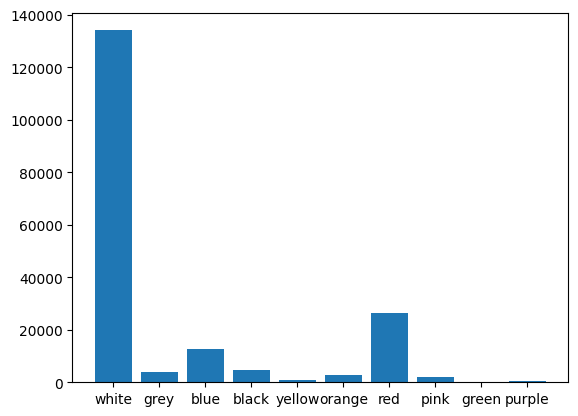

IMAGE NUMBER 11
This image has the following colors {'white': 58952, 'grey': 3307, 'black': 4075, 'blue': 2001, 'pink': 1188, 'orange': 997, 'yellow': 589, 'purple': 144, 'gray': 5, 'green': 68, 'red': 114}


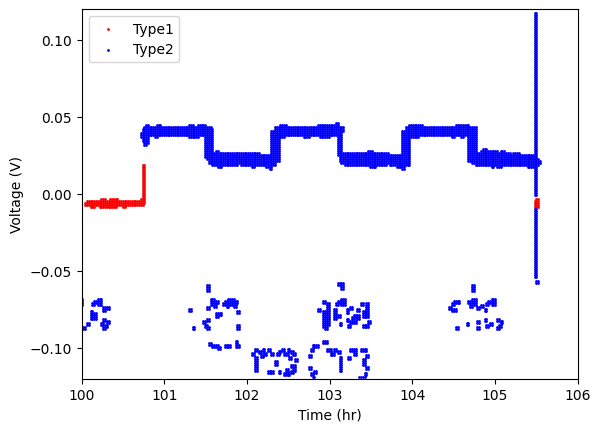

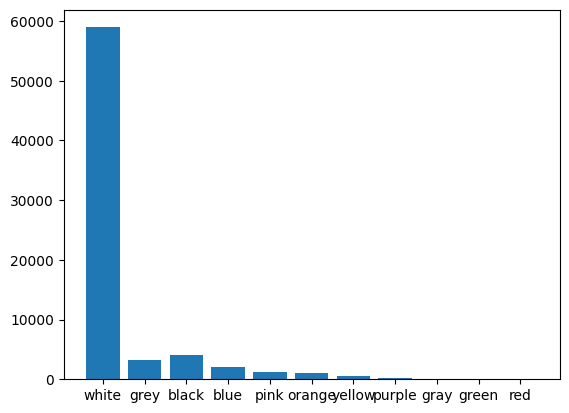

IMAGE NUMBER 12


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


This image has the following colors {'white': 63986, 'grey': 3829, 'blue': 1260, 'black': 4222, 'pink': 52, 'green': 108, 'yellow': 965, 'orange': 4227, 'gray': 132, 'purple': 140, 'red': 39}


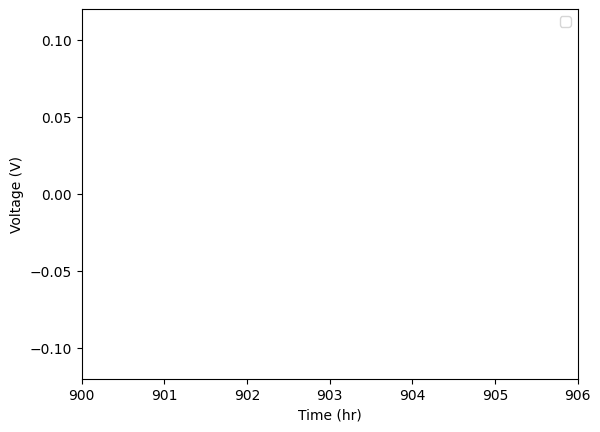

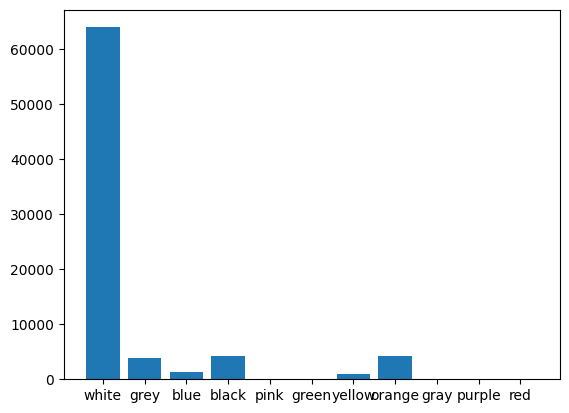

IMAGE NUMBER 13
This image has the following colors {'white': 185303, 'grey': 7746, 'black': 5117, 'blue': 4443, 'orange': 602, 'pink': 2205, 'red': 3151, 'purple': 89}


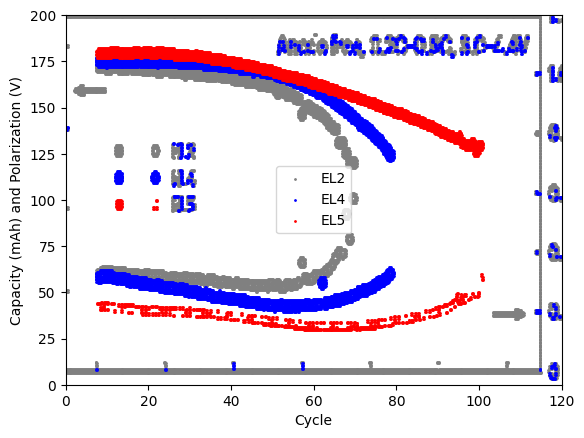

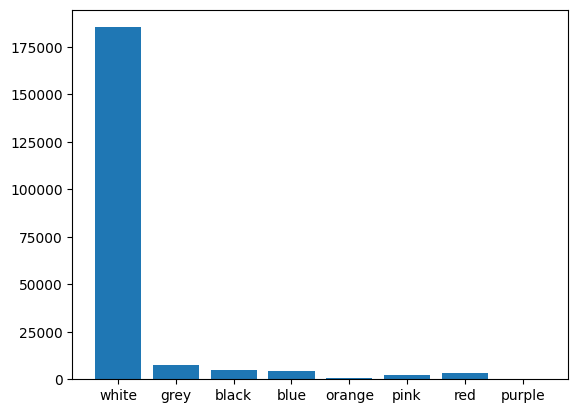

IMAGE NUMBER 14
This image has the following colors {'white': 98531, 'grey': 3717, 'black': 3208, 'blue': 1759, 'pink': 572, 'red': 877, 'orange': 199, 'purple': 21}


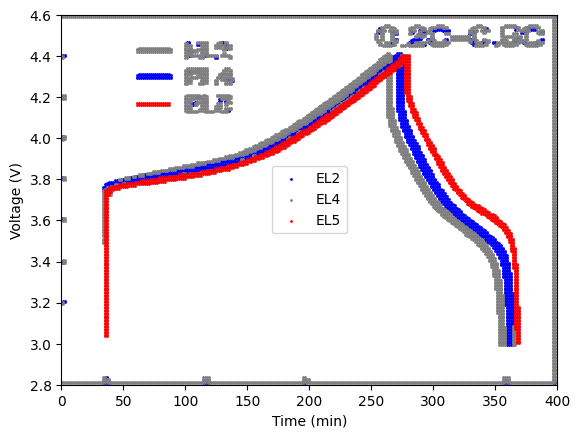

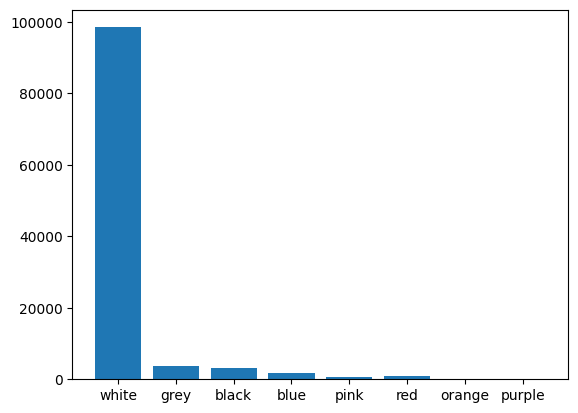

IMAGE NUMBER 15
This image has the following colors {'white': 181093, 'grey': 6109, 'blue': 4083, 'black': 4559, 'pink': 2283, 'red': 3450, 'orange': 639}


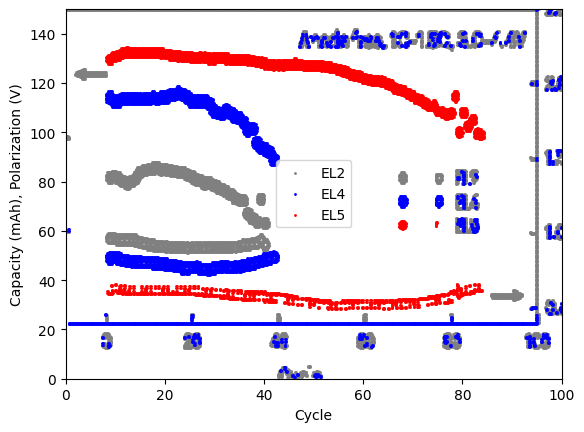

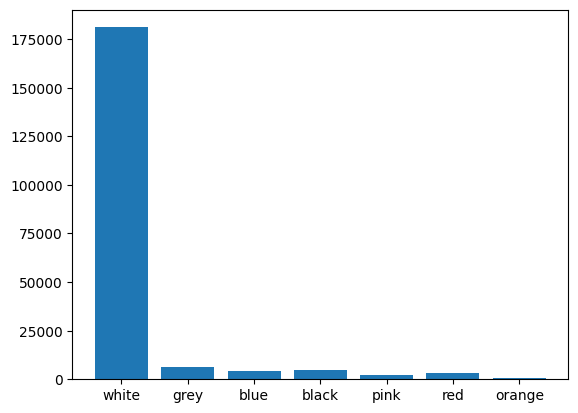

IMAGE NUMBER 16
This image has the following colors {'white': 201785, 'grey': 5733, 'blue': 3718, 'black': 4966, 'pink': 2313, 'red': 4492, 'orange': 661}


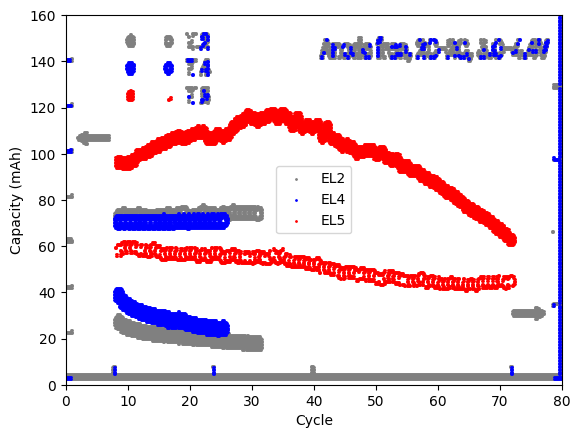

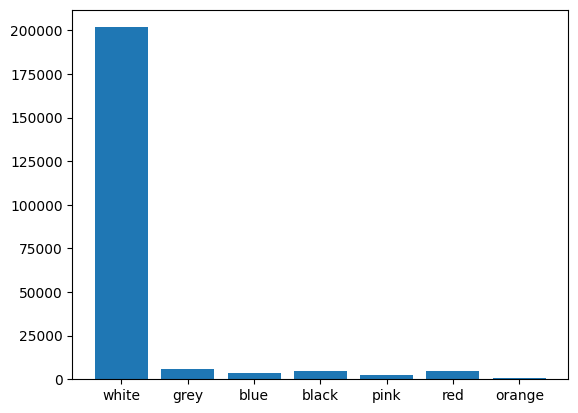

IMAGE NUMBER 17


KeyboardInterrupt: 

In [56]:
import matplotlib.pyplot as plt

for image_num in range(1, 29):
    print("IMAGE NUMBER", image_num)
    prompt = {}
    with open('../plot_json/'+str(image_num)+'.json', 'r') as file:
        prompt = json.load(file)
    image_name, boundingBox = do_analysis(image_num, predictor)

    coordinates, x_axis_title, y_axis_title, axis_labels, rgb_colors, x_range, y_range, memo = do_complete_analysis(1, 1, prompt, image_name, boundingBox, False)

    plt.figure()
    for index, value in enumerate(coordinates):
        x = []
        y = []

        for i in range(len(value)):
            x.append(value[i]["middle"][0])
            y.append(value[i]["middle"][1])

        color_normalized = rgb_colors[index]

        if (is_valid_color(color_normalized)): plt.scatter(x, y, label=axis_labels[index], color=color_normalized, s=1)

    plt.xlim(x_range[0], x_range[1])
    plt.ylim(y_range[0], y_range[1])
    plt.xlabel(x_axis_title)
    plt.ylabel(y_axis_title)
    plt.legend()
    plt.show()

    categories = list(memo.keys())
    frequencies = list(memo.values())
    plt.figure()
    plt.bar(categories, frequencies)
    plt.show()

IMAGE NUMBER 8
This image has the following colors {'white': 153008, 'grey': 3647, 'blue': 4670, 'black': 5983, 'yellow': 1306, 'orange': 212, 'red': 66, 'green': 4079, 'purple': 4, 'pink': 25}


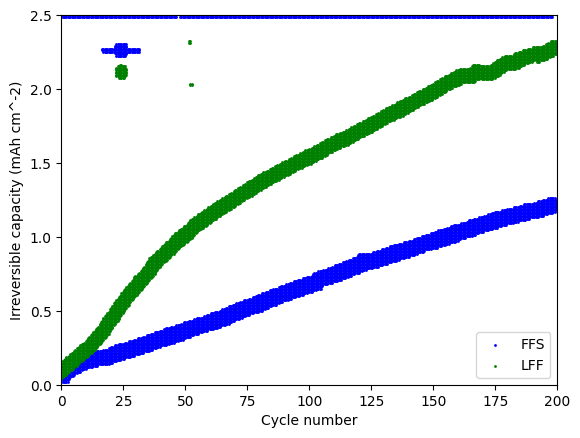

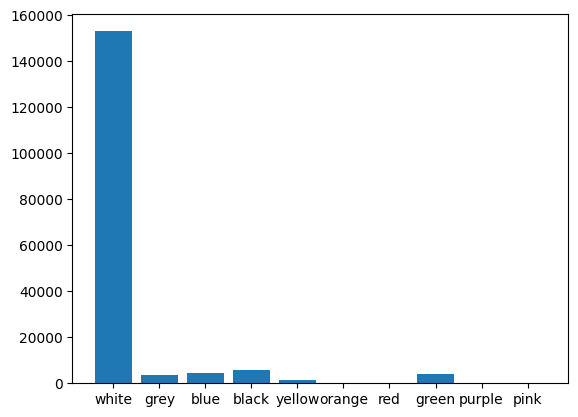

In [53]:
import matplotlib.pyplot as plt
image_num = "8"
print("IMAGE NUMBER", image_num)
prompt = {}
with open('../plot_json/'+str(image_num)+'.json', 'r') as file:
    prompt = json.load(file)
image_name, boundingBox = do_analysis(str(image_num) + "_improved", predictor)

coordinates, x_axis_title, y_axis_title, axis_labels, rgb_colors, x_range, y_range, memo = do_complete_analysis(1, 1, prompt, image_name, boundingBox, False)

plt.figure()
for index, value in enumerate(coordinates):
    x = []
    y = []

    for i in range(len(value)):
        x.append(value[i]["middle"][0])
        y.append(value[i]["middle"][1])

    color_normalized = rgb_colors[index]

    if (is_valid_color(color_normalized)): plt.scatter(x, y, label=axis_labels[index], color=color_normalized, s=1)

plt.xlim(x_range[0], x_range[1])
plt.ylim(y_range[0], y_range[1])
plt.xlabel(x_axis_title)
plt.ylabel(y_axis_title)
plt.legend()
plt.show()

categories = list(memo.keys())
frequencies = list(memo.values())
plt.figure()
plt.bar(categories, frequencies)
plt.show()

IMAGE NUMBER 17
This image has the following colors {'white': 117463, 'grey': 3271, 'blue': 1697, 'black': 3193, 'pink': 462, 'orange': 224, 'red': 907, 'gray': 4, 'purple': 3}


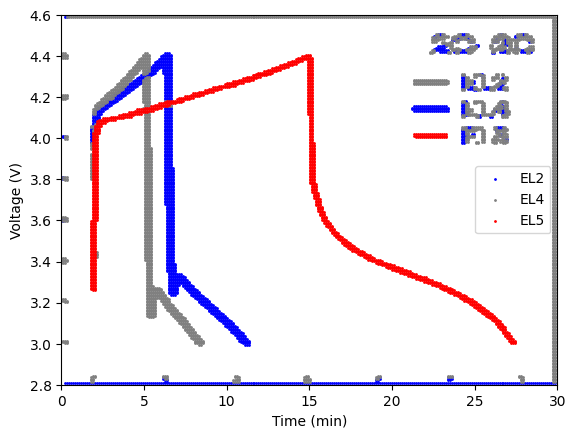

IMAGE NUMBER 18
This image has the following colors {'white': 101975, 'grey': 3751, 'black': 3358, 'blue': 1557, 'pink': 589, 'orange': 193, 'red': 748, 'purple': 4, 'gray': 1}


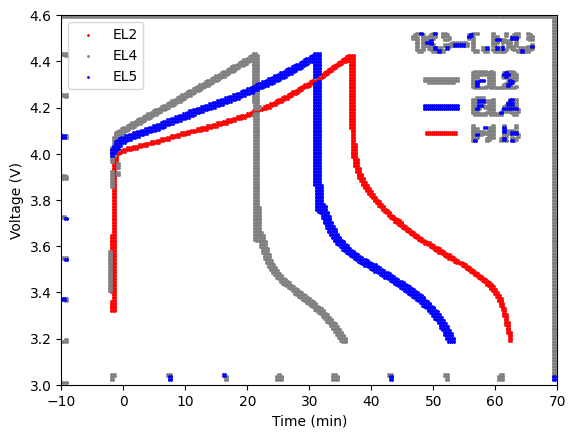

IMAGE NUMBER 19
This image has the following colors {'white': 156496, 'grey': 5241, 'black': 6298, 'blue': 1527, 'orange': 1924, 'yellow': 129, 'red': 1368, 'green': 128, 'pink': 13}


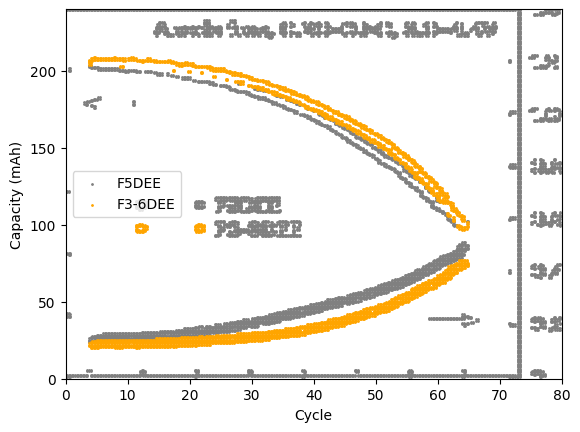

IMAGE NUMBER 20
This image has the following colors {'white': 156339, 'grey': 4256, 'blue': 1515, 'black': 4965, 'orange': 1998, 'red': 1184, 'yellow': 184, 'pink': 1, 'green': 54}


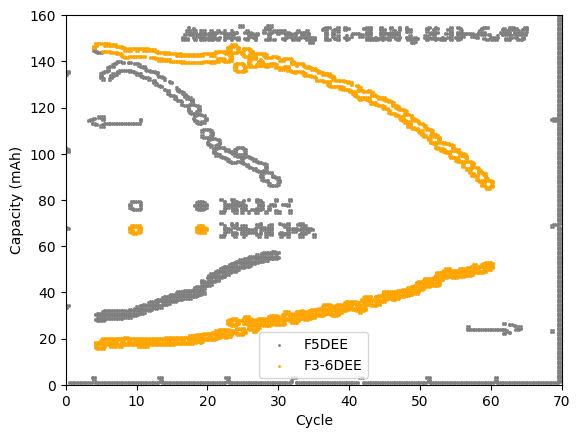

IMAGE NUMBER 21
This image has the following colors {'white': 162549, 'grey': 3613, 'black': 4907, 'blue': 1407, 'orange': 1063, 'red': 462, 'yellow': 114, 'green': 77}


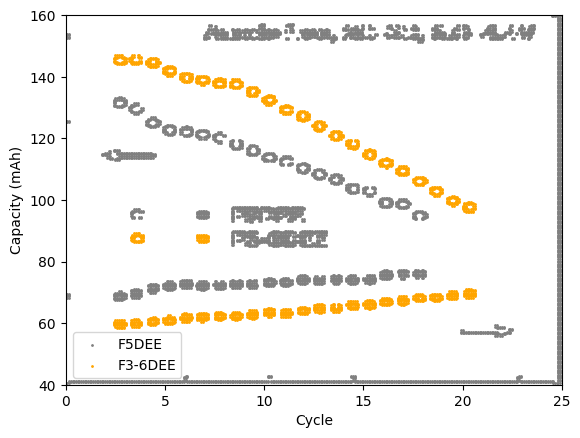

IMAGE NUMBER 22
This image has the following colors {'white': 1203503, 'grey': 15935, 'blue': 8712, 'black': 41168, 'pink': 6139, 'orange': 1001, 'red': 5710, 'gray': 24}


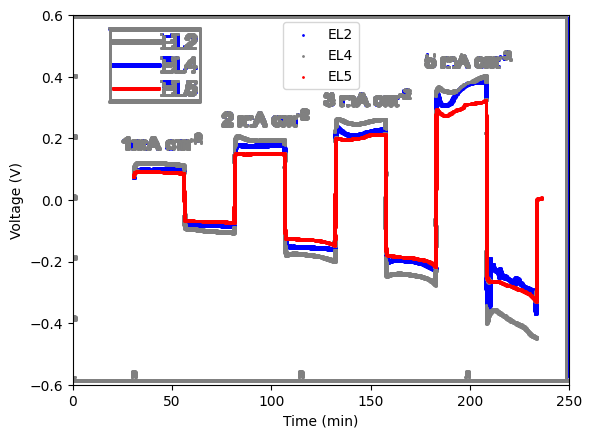

IMAGE NUMBER 23
This image has the following colors {'white': 860479, 'grey': 12582, 'black': 29269, 'blue': 7835, 'red': 1802, 'orange': 674, 'pink': 4383, 'gray': 172}


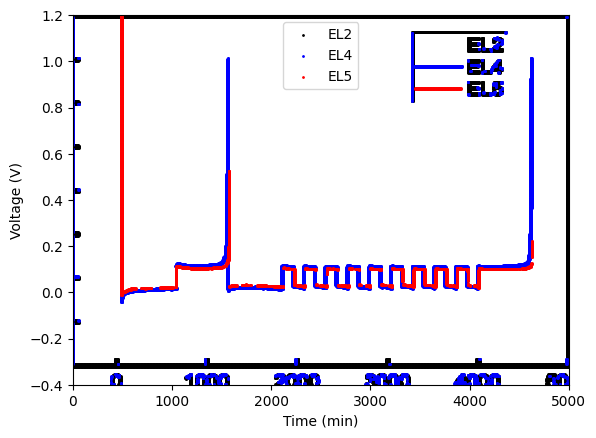

IMAGE NUMBER 24
This image has the following colors {'white': 837247, 'grey': 16507, 'black': 28996, 'blue': 12630, 'red': 1577, 'pink': 6421, 'orange': 1822, 'gray': 20}


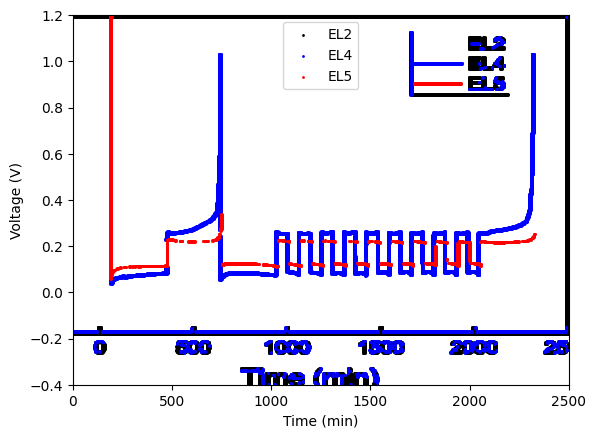

IMAGE NUMBER 25
This image has the following colors {'white': 833536, 'grey': 30244, 'black': 32680, 'blue': 14149, 'green': 64, 'gray': 490, 'pink': 12132, 'orange': 3766, 'red': 12463, 'yellow': 78, 'purple': 38}


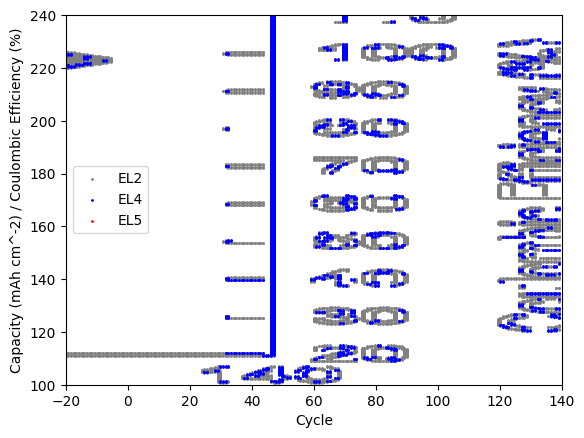

IMAGE NUMBER 26
This image has the following colors {'white': 895257, 'grey': 21641, 'blue': 12520, 'black': 30475, 'gray': 230, 'pink': 10769, 'orange': 2988, 'red': 11414, 'purple': 37, 'yellow': 61, 'green': 16}


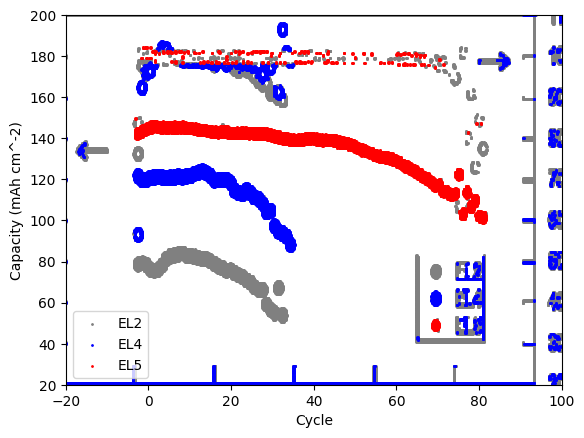

IMAGE NUMBER 27
This image has the following colors {'white': 930080, 'grey': 22504, 'blue': 13059, 'black': 33366, 'gray': 259, 'purple': 38, 'pink': 10537, 'orange': 2956, 'red': 11775, 'green': 22, 'yellow': 68}


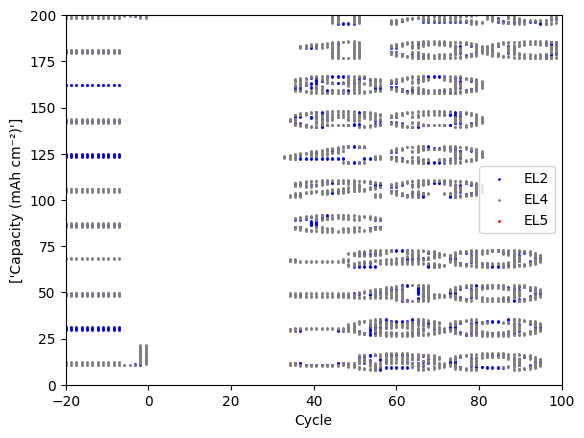

IMAGE NUMBER 28
This image has the following colors {'white': 277637, 'grey': 6105, 'blue': 4478, 'black': 14146, 'pink': 1097, 'orange': 3988, 'red': 12010, 'purple': 773, 'green': 6, 'yellow': 492}


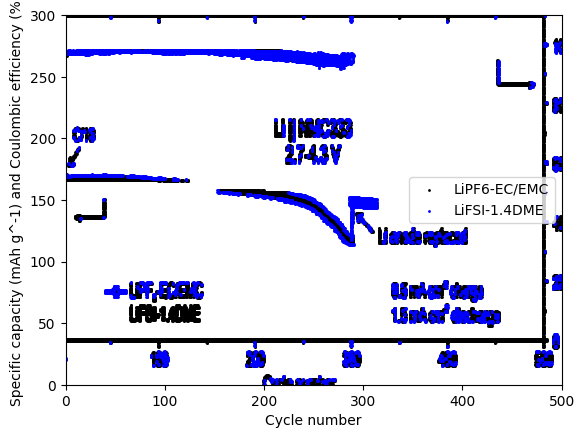

In [12]:
import matplotlib.pyplot as plt

for image_num in range(17, 29):
    print("IMAGE NUMBER", image_num)
    prompt = {}
    with open('../plot_json/'+str(image_num)+'.json', 'r') as file:
        prompt = json.load(file)
    image_name, boundingBox = do_analysis(image_num, predictor)

    coordinates, x_axis_title, y_axis_title, axis_labels, rgb_colors, x_range, y_range, memo = do_complete_analysis(1, 1, prompt, image_name, boundingBox, False)

    plt.figure()
    for index, value in enumerate(coordinates):
        x = []
        y = []

        for i in range(len(value)):
            x.append(value[i]["middle"][0])
            y.append(value[i]["middle"][1])

        color_normalized = rgb_colors[index]

        if (is_valid_color(color_normalized)): plt.scatter(x, y, label=axis_labels[index], color=color_normalized, s=1)

    plt.xlim(x_range[0], x_range[1])
    plt.ylim(y_range[0], y_range[1])
    plt.xlabel(x_axis_title)
    plt.ylabel(y_axis_title)
    plt.legend()
    plt.show()

    